In [1]:
from PIL import Image, ImageDraw
import os
import numpy as np
import tensorflow.compat.v1 as tf
import csv
import datetime
import contextlib
import threading
import concurrent, concurrent.futures

In [196]:
uurl = '120002388194615_В111ЕТ48.jpg'
auto_im = Image.open('detect_test/auto.out/' + uurl)
regno_im = Image.open('detect_test/regno.out/' + uurl)

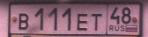

In [197]:
regno_im

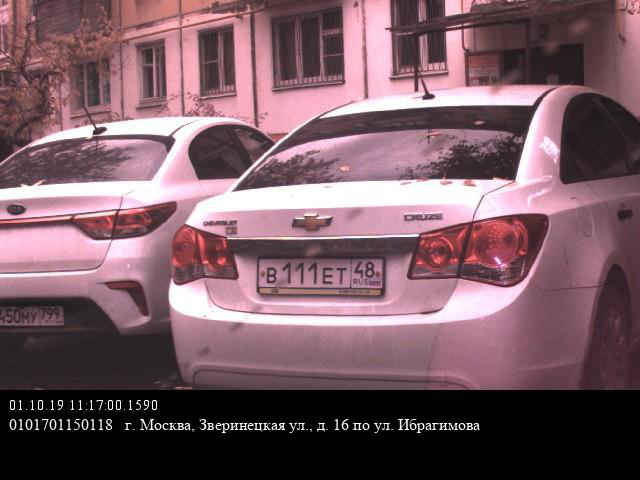

In [198]:
auto_im

In [199]:
regno = np.array(regno_im)
if len(regno.shape) == 3:
    regno = np.average(regno, axis=2).astype(np.float)
auto = np.array(auto_im)
if len(auto.shape) == 3:
    auto = np.average(auto, axis=2).astype(np.float)


In [200]:
regno.shape, auto.shape

((37, 148), (480, 640))

In [201]:
def my_stat(x, y):
    x_ = x.mean()
    y_ = y.mean()
    x_mean = x - x_
    y_mean = y - y_
    m = np.linalg.norm(x_mean) * np.linalg.norm(y_mean)
    if m == 0:
        return 0
    else:
        return (x_mean * y_mean).sum() / m
    

In [202]:
def get_regno_rect(regno, auto):
    h_regno, w_regno = regno.shape
    h_auto, w_auto = auto.shape

    mask = np.zeros((h_auto - h_regno, w_auto - w_regno)).astype(np.uint8)

    for i in range(h_auto - h_regno):
        for j in range(w_auto - w_regno):
            mask[i,j] = abs(my_stat(auto[i:i + h_regno, j:j + w_regno].ravel(), regno.ravel())) * 255.
    
    max_ = 0
    max_i = 0
    max_j = 0
    for l in range(mask.shape[0]):
        for m in range(mask.shape[1]):
            if mask[l:l + 4, m:m + 4].sum() > max_:
                max_ = mask[l:l + 4, m:m + 4].sum()
                max_i = l
                max_j = m    
    return max_i, max_j

In [203]:
%%time
get_regno_rect(regno, auto)

CPU times: user 35.7 s, sys: 291 ms, total: 36 s
Wall time: 12.2 s


(252, 244)

In [204]:
def quick_get_regno_rect(auto, regno):
    n1,n2 = auto.shape
    m1,m2 = regno.shape
    regno_ = np.hstack((regno, np.zeros((regno.shape[0], n2 - m2))))
    regno_ = np.vstack((regno_, np.zeros((n1 - m1, regno_.shape[1]))))

    e = np.ones((m1,m2))
    e = np.hstack((e, np.zeros((e.shape[0], n2 - m2))))
    e = np.vstack((e, np.zeros((n1 - m1, e.shape[1]))))
    
    xy = np.fft.ifft2((np.fft.fft2(auto)*np.fft.fft2(regno_).conjugate())).real
    xx = np.fft.ifft2((np.fft.fft2(auto*auto)*np.fft.fft2(e).conjugate())).real
    mask2 = np.divide(xy, np.round(xx)**0.5, out=np.zeros_like(xy), where=(np.round(xx)**0.5)!=0)
    max_ = 0
    max_i = 0
    max_j = 0
    d = 2
    for l in range(mask2.shape[0] - regno.shape[0]):
        for m in range(mask2.shape[1] - regno.shape[1]):
            if mask2[l:l + d, m:m + d].sum() > max_:
                max_ = mask2[l:l + d, m:m + d].sum()
                max_i = l
                max_j = m
    return max_i, max_j

In [205]:
%%time
quick_get_regno_rect(auto, regno)

CPU times: user 3.08 s, sys: 641 ms, total: 3.72 s
Wall time: 1.22 s


(253, 246)

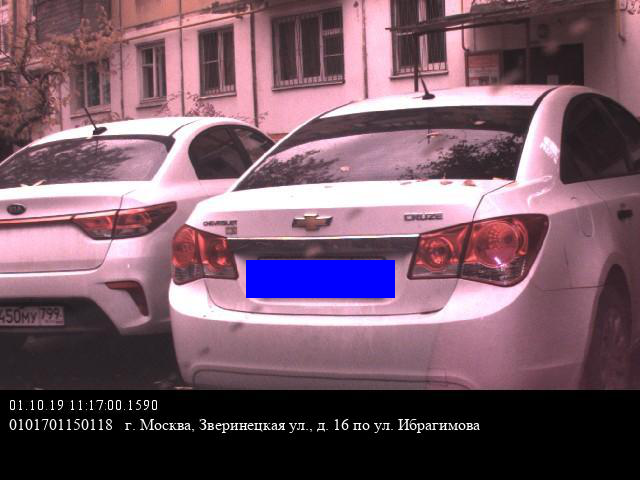

In [210]:
i = 260
j = 246

di, dj = regno.shape

d_im = Image.open('detect_test/auto.out/' + uurl)
draw = ImageDraw.Draw(d_im)

draw.rectangle(((j,i), (j+dj, i+di)), fill='blue', width=3)
d_im

In [11]:
n1,n2 = auto.shape
m1,m2 = regno.shape

In [223]:
regno = np.hstack((regno, np.zeros((regno.shape[0], n2 - m2))))
regno = np.vstack((regno, np.zeros((n1 - m1, regno.shape[1]))))

e = np.ones((m1,m2))
e = np.hstack((e, np.zeros((e.shape[0], n2 - m2))))
e = np.vstack((e, np.zeros((n1 - m1, e.shape[1]))))


In [224]:
xy = np.fft.ifft2((np.fft.fft2(auto)*np.fft.fft2(regno).conjugate())).real
xx = np.fft.ifft2((np.fft.fft2(auto*auto)*np.fft.fft2(e).conjugate())).real


#mask = (xy/np.sqrt(xx))/((regno*regno).sum())**(0.5)
mask2 = np.divide(xy, np.round(xx)**0.5, out=np.zeros_like(xy), where=(np.round(xx)**0.5)!=0)/((regno*regno).sum())**(0.5)

In [225]:
max_ = 0
max_i = 0
max_j = 0
d = 4
for l in range(mask2.shape[0]):
    for m in range(mask2.shape[1]):
        if mask2[l:l + d, m:m + d].sum() > max_:
            max_ = mask2[l:l + d, m:m + d].sum()
            max_i = l
            max_j = m
max_i,max_j

(33, 142)

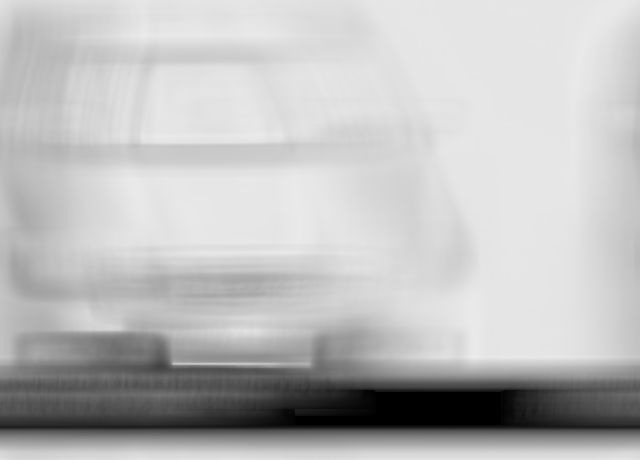

In [226]:
Image.fromarray((mask2*255).astype(np.uint8), mode='L')

## Проверка разметки

In [16]:
import numpy as np
import random
import os
from PIL import Image, ImageDraw
import pandas as pd

In [88]:
data = pd.read_csv('detect_train_v2.csv')
data.head()

,tr_check_id,regno,y,x,heigth,width,bw
0,70002284429532,К933УХ197,85,307,28,86,0
1,160002229854089,Е405КЕ50,275,310,27,85,0
2,160002229250788,О537ОА799,228,313,27,86,0
3,110002995382168,НР68077,357,157,37,148,0
4,180002289356319,Е758КХ99,254,243,36,148,0


In [89]:
i = 1
for tr_check_id, regno, y, x, height, width, bw in data[data.bw == 0].sample(50).values:
    image = Image.open(f'auto.out/{tr_check_id}_{regno}.jpg')
    draw = ImageDraw.Draw(image)
    
    draw.rectangle(((x, y), (x + width, y + height)), outline='blue', width=3)
    image.save(f'{i}.jpg')
    print(i,f'auto.out/{tr_check_id}_{regno}.jpg',height, width)
    i += 1

1 auto.out/280001694299926_Т691ЕО799.jpg 37 148
2 auto.out/90001824107017_Х868ХТ190.jpg 36 148
3 auto.out/60002169362808_С848СВ190.jpg 33 112
4 auto.out/90001824275869_Х624ОК197.jpg 36 148
5 auto.out/270002295213486_Н271НМ750.jpg 38 148
6 auto.out/280001694197857_С022ЕС199.jpg 36 148
7 auto.out/200001961884838_Р862ТС777.jpg 37 148
8 auto.out/160002229297741_М740ВЕ799.jpg 34 113
9 auto.out/320001712749456_У619РВ799.jpg 27 85
10 auto.out/310002193242449_О165УВ750.jpg 37 148
11 auto.out/90001824420842_Р822СЕ750.jpg 36 148
12 auto.out/310002193083529_Е817КХ177.jpg 37 148
13 auto.out/320001712729877_Т550КВ799.jpg 35 103
14 auto.out/70002284292633_Е386КС777.jpg 37 148
15 auto.out/90001824422967_Х005АЕ777.jpg 36 148
16 auto.out/10002553569829_К390МН799.jpg 36 148
17 auto.out/10002553398423_В948МХ152.jpg 37 148
18 auto.out/170001934894561_Т255ТЕ750.jpg 37 148
19 auto.out/10002553666878_Р768ТК777.jpg 36 148
20 auto.out/200001961695127_В312КР197.jpg 37 148
21 auto.out/190001762007493_С999ВХ777.j

#### продолжение проверки

In [124]:
data = pd.read_excel('detect_train.xlsx')
data.head()

,tr_check_id,regno,y,x,heigth,width,bw,y_v2,x_v2,y_v3,x_v3,r12,r13,r23,all,two
0,70002284429532,К933УХ197,85,307,28,86,0,86,308,85,307,1.414214,0.000000,1.414214,1,0
1,160002229854089,Е405КЕ50,275,310,27,85,0,275,310,275,310,0.000000,0.000000,0.000000,1,0
2,160002229250788,О537ОА799,228,313,27,86,0,228,313,227,312,0.000000,1.414214,1.414214,1,0
3,110002995382168,НР68077,357,157,37,148,0,395,328,106,346,175.171345,314.200573,289.560011,0,0
4,180002289356319,Е758КХ99,254,243,36,148,0,254,243,254,243,0.000000,0.000000,0.000000,1,0


In [192]:
a = data[data[['all','two']].apply(lambda x: True if x[0] == 0 and x[1] == 0 else False,axis=1)].sample(100)

In [193]:
def xy(row):
    argmin = np.array([row['r12'],row['r23'],row['r13']]).argmin()
    
    return (row['tr_check_id'], 
            row['regno'],
            #[row['y'], row['y_v2'], row['y_v3']][argmin],
            #[row['x'], row['x_v2'], row['x_v3']][argmin], 
            row['y'],
            row['x'],
            row['heigth'],
            row['width'],
            row['bw'])


In [195]:
i = 1
for tr_check_id, regno, y, x, height, width, bw in a.apply(xy, axis=1):
    image = Image.open(f'auto.out/{tr_check_id}_{regno}.jpg')
    draw = ImageDraw.Draw(image)
    
    draw.rectangle(((x, y), (x + width, y + height)), outline='blue', width=3)
    image.save(f'{i}.jpg')
    print(i,f'auto.out/{tr_check_id}_{regno}.jpg',height, width)
    i += 1

1 auto.out/220002226389148_Х608УО750.jpg 32 124
2 auto.out/320001712047713_Х859ХЕ777.jpg 33 116
3 auto.out/270002295084622_К427АН777.jpg 38 148
4 auto.out/130002497163356_С112ХР77.jpg 32 120
5 auto.out/210001352810178_О520ХО199.jpg 40 154
6 auto.out/60002169398866_Е143НМ777.jpg 32 112
7 auto.out/310002193323650_М377РН177.jpg 23 83
8 auto.out/280001694636014_С714ОО76.jpg 37 148
9 auto.out/240002354546222_В367РМ99.jpg 36 132
10 auto.out/280001694348918_У575ТР77.jpg 36 136
11 auto.out/280001694599746_В697НХ799.jpg 38 148
12 auto.out/180002289629054_С371ЕР99.jpg 38 143
13 auto.out/30002200345121_Р656КМ190.jpg 27 89
14 auto.out/310002193094586_Р661ЕК76.jpg 18 72
15 auto.out/240002354468269_Т783ТУ777.jpg 30 117
16 auto.out/310002193137608_К347ТН777.jpg 35 135
17 auto.out/180002289155149_К087РА777.jpg 21 121
18 auto.out/310002193507507_Х008МО99.jpg 24 93
19 auto.out/120002387693463_М197ЕР197.jpg 17 66
20 auto.out/70002283911848_Н404ЕО199.jpg 38 148
21 auto.out/210001353058167_М462УВ750.jpg 40